# New York City Taxi Fare Prediction Playground Competition
Many Thanks to Albert van Breemen who created a great notebook, which I forked to use as a starting point for my own data exploration and file prep:
https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

## Reading data and first exploration

In [1]:
## Load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
## Read data in pandas dataframe, using nrows for exploration, then chunksize for later processing.
train_df =  pd.read_csv('./datafiles/train.csv', nrows=200000, parse_dates=["pickup_datetime"])  ##TODO: change nrows back to 2m

## List first few rows (datapoints)
train_df.head()

key  fare_amount     pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [3]:
## Check datatypes
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [4]:
## Check statistics of the features
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  200000.000000     200000.000000    200000.000000      199999.000000   
mean       11.342877        -72.506121        39.922326         -72.518673   
std         9.837855         11.608097        10.048947          10.724226   
min       -44.900000       -736.550000     -3116.285383       -1251.195890   
25%         6.000000        -73.992050        40.735007         -73.991295   
50%         8.500000        -73.981743        40.752761         -73.980072   
75%        12.500000        -73.967068        40.767127         -73.963508   
max       500.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count  
count     199999.000000    200000.000000  
mean          39.925579         1.682445  
std            6.751120         1.306730  
min        -1189.615440         0.000000  
25%           40.734092         1.000000  
50%           40.753225         1.000000  
75%           40.768070         2.000000  
max          404.616667         6.000000

### First observations

- There are negative fares.  And while they may have a good explanation for why they're in the dataset (such as due to refunds), I don't think it's reasonable to expect that a significant portion of the test dataset would feature negative fares.  And, since we've got a gigantic dataset, there's little harm in dropping any data that contains unhelpful information.
 - Furthermore, in researching the NYC Taxi rates, I see that that standard base charge for any taxi is $2.50, so I'm dropping everything from the dataset that's less than that.
- Is there any missing data?  If so, how many rows are affected?  Does the test set contain missing data?

- Swapped Lat/Lon? Or just junk coordinates?
- 0 Passengers?
- Bucketize Dates

## Compare test data
Load the test data to sanity check any changes to the train set.

In [5]:
## Read data in pandas dataframe
test_df =  pd.read_csv('./datafiles/test.csv', parse_dates=["pickup_datetime"])
test_df.head(5)

key     pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002 2015-01-27 13:08:24        -73.973320   
1  2015-01-27 13:08:24.0000003 2015-01-27 13:08:24        -73.986862   
2  2011-10-08 11:53:44.0000002 2011-10-08 11:53:44        -73.982524   
3  2012-12-01 21:12:12.0000002 2012-12-01 21:12:12        -73.981160   
4  2012-12-01 21:12:12.0000003 2012-12-01 21:12:12        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1

In [6]:
test_df.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count  
count      9914.000000  
mean          1.671273  
std           1.278747  
min           1.000000  
25%           1.000000  
50%           1.000000  
75%           2.000000  
max           6.000000

## Remove all fares less than $2.50

In [7]:
def fix_fares(df, verbose=False):
    if verbose:
        print("Removing all fares less than $2.50:")
        old_size = len(df)
        print("Old size: {}".format(old_size))

    df = df[df.fare_amount >= 2.5]

    if verbose:
        new_size = len(df)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df

train_df = fix_fares(train_df, True)

Removing all fares less than $2.50:
Old size: 200000
New size: 199978
Dropped 22 records, or 0.01%


## Remove missing data

Next up, lets check to see how much missing data exists in this dataset and compare it to the test set.  Then we'll drop any rows with missing data from the training set, since it'd be better to use less data than to let bad data influence the model.

In [8]:
print("Train Dataset NaNs: {}".format(train_df.isnull().sum()))

print("Test Dataset NaNs: {}".format(test_df.isnull().sum()))

Train Dataset NaNs: key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
Test Dataset NaNs: key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [9]:
def drop_nan(df, verbose=False):
    if verbose:
        print("Dropping all rows with NaNs:")
        old_size = len(df)
        print("Old size: {}".format(old_size))

    df.dropna(how ='any', axis ='rows', inplace=True)

    if verbose:
        new_size = len(df)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df

train_df = drop_nan(train_df, True)

Dropping all rows with NaNs:
Old size: 199978
New size: 199977
Dropped 1 records, or 0.00%


## Investigate Lat and Lon outliers
First, lets check to see if the test set has any outliers.

In [10]:
## Minimum and maximum longitude test set
min(test_df.pickup_longitude.min(), test_df.dropoff_longitude.min()), \
max(test_df.pickup_longitude.max(), test_df.dropoff_longitude.max())

(-74.263242000000005, -72.986531999999997)

In [11]:
## Minimum and maximum latitude test
min(test_df.pickup_latitude.min(), test_df.dropoff_latitude.min()), \
max(test_df.pickup_latitude.max(), test_df.dropoff_latitude.max())

(40.568973, 41.709555000000002)

In [12]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[(df['pickup_longitude'] < BB[0]) | (df['pickup_longitude'] > BB[1]) | \
           (df['pickup_latitude'] < BB[2]) | (df['pickup_latitude'] > BB[3]) | \
           (df['dropoff_longitude'] < BB[0]) | (df['dropoff_longitude'] > BB[1]) | \
           (df['dropoff_latitude'] < BB[2]) | (df['dropoff_latitude'] > BB[3])]
    
    return filter_df

NYC_BB = (-74.5, -72.8, 40.5, 41.8)

In [13]:
latlon_outliers = select_outside_boundingbox(train_df, NYC_BB)

print("Train Dataset outliers: {}".format(latlon_outliers.sum()))

latlon_outliers

Train Dataset outliers: key                  2012-12-24 11:24:00.000000982013-11-23 12:57:0...
fare_amount                                                    50772.8
pickup_longitude                                              -15719.2
pickup_latitude                                                4730.45
dropoff_longitude                                             -18588.3
dropoff_latitude                                               5397.12
passenger_count                                                   7007
dtype: object


key  fare_amount     pickup_datetime  \
11       2012-12-24 11:24:00.00000098         5.50 2012-12-24 11:24:00   
15      2013-11-23 12:57:00.000000190         5.00 2013-11-23 12:57:00   
26      2011-02-07 20:01:00.000000114         6.50 2011-02-07 20:01:00   
124      2013-01-17 17:22:00.00000043         8.00 2013-01-17 17:22:00   
192      2010-09-05 17:08:00.00000092         3.70 2010-09-05 17:08:00   
233       2011-07-24 01:14:35.0000002         8.50 2011-07-24 01:14:35   
273      2009-10-30 18:13:00.00000021         8.10 2009-10-30 18:13:00   
357       2013-07-04 16:41:27.0000002         8.50 2013-07-04 16:41:27   
376       2014-05-29 05:57:22.0000001         2.50 2014-05-29 05:57:22   
387      2012-11-15 08:39:00.00000095        13.00 2012-11-15 08:39:00   
472     2009-02-22 22:48:00.000000130         2.50 2009-02-22 22:48:00   
498       2009-03-16 04:47:17.0000001        17.00 2009-03-16 04:47:17   
540       2013-10-29 01:09:14.0000002        16.00 2013-10-29 01:09:14   
542     2009-12-29 14:23:00.000000158         4.50 2009-12-29 14:23:00   
568       2014-10-08 06:49:18.0000001         6.50 2014-10-08 06:49:18   
660       2010-08-18 03:46:00.0000002        13.30 2010-08-18 03:46:00   
728       2010-02-13 01:52:11.0000003        11.70 2010-02-13 01:52:11   
799      2013-12-08 23:39:00.00000080         3.00 2013-12-08 23:39:00   
872     2011-09-25 02:07:00.000000139         8.50 2011-09-25 02:07:00   
881       2011-07-19 23:43:12.0000001         8.50 2011-07-19 23:43:12   
887       2014-09-26 19:41:41.0000004        12.00 2014-09-26 19:41:41   
958      2011-02-22 14:09:00.00000066         2.50 2011-02-22 14:09:00   
960       2013-05-31 05:02:30.0000001        12.50 2013-05-31 05:02:30   
964       2009-06-30 10:20:09.0000005        14.10 2009-06-30 10:20:09   
966       2015-06-08 01:59:17.0000001        28.00 2015-06-08 01:59:17   
1181    2012-10-11 00:21:00.000000140        25.00 2012-10-11 00:21:00   
1260     2011-03-10 20:25:00.00000049         5.70 2011-03-10 20:25:00   
1314      2012-09-20 20:06:50.0000001        11.50 2012-09-20 20:06:50   
1316    2014-06-17 17:50:00.000000213         8.50 2014-06-17 17:50:00   
1397     2009-02-17 07:30:00.00000027         4.50 2009-02-17 07:30:00   
...                               ...          ...                 ...   
198525   2014-06-28 03:49:00.00000048         8.00 2014-06-28 03:49:00   
198527  2011-11-30 08:23:00.000000138         5.30 2011-11-30 08:23:00   
198538  2012-04-09 21:09:00.000000144         6.50 2012-04-09 21:09:00   
198597  2014-05-23 16:05:00.000000115        16.50 2014-05-23 16:05:00   
198726   2014-02-24 19:07:43.00000012        10.00 2014-02-24 19:07:43   
198757    2015-04-20 15:38:00.0000001       118.18 2015-04-20 15:38:00   
198872    2015-01-31 20:49:43.0000006        11.00 2015-01-31 20:49:43   
198930   2011-09-02 01:34:00.00000062         8.50 2011-09-02 01:34:00   
199041   2009-10-26 15:04:00.00000033         8.10 2009-10-26 15:04:00   
199054    2012-06-04 16:50:33.0000001        12.10 2012-06-04 16:50:33   
199163    2015-02-12 22:13:19.0000006         6.50 2015-02-12 22:13:19   
199175    2011-07-26 06:19:19.0000001         8.50 2011-07-26 06:19:19   
199218    2011-07-21 23:32:41.0000003         4.50 2011-07-21 23:32:41   
199236   2010-11-10 11:27:00.00000069        10.50 2010-11-10 11:27:00   
199241    2013-02-12 14:57:26.0000001         6.00 2013-02-12 14:57:26   
199510    2011-12-20 21:21:59.0000003         4.10 2011-12-20 21:21:59   
199518    2014-11-22 21:52:25.0000001         9.00 2014-11-22 21:52:25   
199597   2012-05-07 14:10:00.00000060         4.50 2012-05-07 14:10:00   
199695   2009-09-18 02:14:00.00000097        11.40 2009-09-18 02:14:00   
199723    2014-05-27 04:57:46.0000001        52.00 2014-05-27 04:57:46   
199736   2009-02-08 04:35:00.00000044         3.40 2009-02-08 04:35:00   
199748   2011-09-22 23:52:00.00000063        16.90 2011-09-22 23:52:00   
199770   2013-02-22 20:14:00.00000066 

## Remove 0's from dataset

I'm noticing a lot of rows with at least one 0 in a column (Latitude, Longitude, and/or Passengers), which doesn't make much sense in the scope of this problem, so I'm going to drop all rows with a 0, as junk data.

In [14]:
def drop_0s(df, verbose=False):
    if verbose:
        print("Dropping all rows with 0s:")
        old_size = len(df)
        print("Old size: {}".format(old_size))

    df = df.loc[~(df == 0).any(axis=1)]

    if verbose:
        new_size = len(df)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df

train_df = drop_0s(train_df, True)

train_df.describe()

Dropping all rows with 0s:
Old size: 199977
New size: 195331
Dropped 4646 records, or 2.32%


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  195331.000000     195331.000000    195331.000000      195331.000000   
mean       11.338814        -73.902923        40.703734         -73.914292   
std         9.770665          5.852132         4.591090           3.756357   
min         2.500000       -736.550000       -74.007670       -1251.195890   
25%         6.000000        -73.992258        40.736584         -73.991470   
50%         8.500000        -73.982037        40.753497         -73.980489   
75%        12.500000        -73.968270        40.767532         -73.965119   
max       500.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count  
count     195331.000000    195331.000000  
mean          40.691156         1.688877  
std            3.919216         1.305417  
min        -1189.615440         1.000000  
25%           40.735610         1.000000  
50%           40.753930         1.000000  
75%           40.768372         2.000000  
max          404.616667         6.000000

In [15]:
latlon_outliers = drop_0s(latlon_outliers, True)

latlon_outliers.describe()

Dropping all rows with 0s:
Old size: 4183
New size: 236
Dropped 3947 records, or 94.36%


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count   236.000000        236.000000       236.000000         236.000000   
mean     14.095339        -14.254380         1.477502         -24.541671   
std      17.202911        157.757799       126.380717          96.312424   
min       2.900000       -736.550000       -74.007670       -1251.195890   
25%       6.500000        -73.985488       -73.973902         -73.981125   
50%       9.500000         -7.666666        39.603671          -1.271542   
75%      14.900000         40.742905        40.706894          40.744823   
max     200.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count  
count        236.000000       236.000000  
mean          -9.219342         1.902542  
std          101.300144         1.522538  
min        -1189.615440         1.000000  
25%          -73.969469         1.000000  
50%           39.604200         1.000000  
75%           40.728849         2.000000  
max          404.616667         6.000000

Now it looks like a significant portion of these might have useable data, just with the latitude and/or longitude accidentally swapped.  Let's graph it out to see what we're dealing with. 

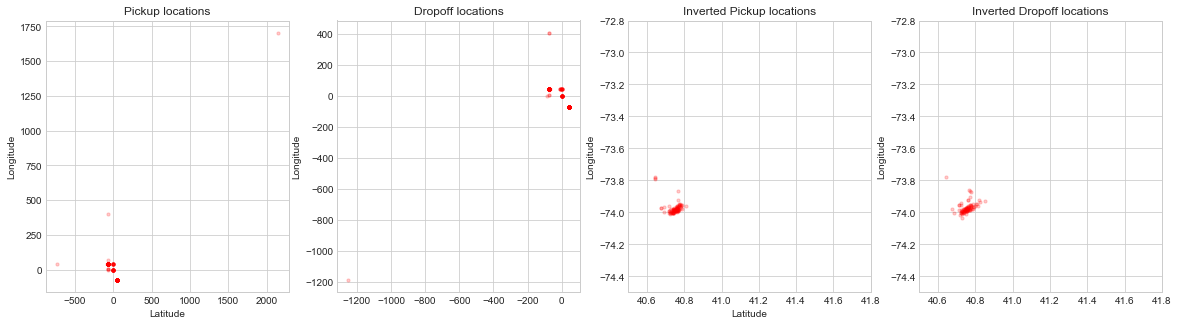

In [16]:
import matplotlib.patches as patches

def plot(df, BB, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlabel('Latitude')
    axs[0].set_ylabel('Longitude')
    axs[0].set_title('Pickup locations')

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_ylabel('Latitude')
    axs[1].set_ylabel('Longitude')
    axs[1].set_title('Dropoff locations')
    
    axs[2].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[2].set_xlim((BB[2], BB[3]))
    axs[2].set_xlabel('Latitude')
    axs[2].set_ylim((BB[0], BB[1]))
    axs[2].set_ylabel('Longitude')
    axs[2].set_title('Inverted Pickup locations')

    axs[3].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[3].set_xlim((BB[2], BB[3]))
    axs[3].set_ylabel('Latitude')
    axs[3].set_ylim((BB[0], BB[1]))
    axs[3].set_ylabel('Longitude')
    axs[3].set_title('Inverted Dropoff locations')
    
plot(latlon_outliers, NYC_BB)

In [17]:
def select_within_boundingbox(df, BB):
    filter_df = df.loc[(df['pickup_longitude'] >= BB[0]) & (df['pickup_longitude'] <= BB[1]) & \
           (df['pickup_latitude'] >= BB[2]) & (df['pickup_latitude'] <= BB[3]) & \
           (df['dropoff_longitude'] >= BB[0]) & (df['dropoff_longitude'] <= BB[1]) & \
           (df['dropoff_latitude'] >= BB[2]) & (df['dropoff_latitude'] <= BB[3])]
    
    return filter_df

inverted_NYC_BB = (40.5, 41.8, -74.5, -72.8)

inverted_outliers = select_within_boundingbox(latlon_outliers, inverted_NYC_BB)

inverted_outliers.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count    90.000000         90.000000        90.000000          90.000000   
mean     13.905444         40.747626       -73.973014          40.753956   
std      11.906948          0.029900         0.040955           0.030683   
min       3.500000         40.643865       -74.007670          40.644732   
25%       7.125000         40.740184       -73.991628          40.734690   
50%      10.000000         40.754954       -73.982319          40.755594   
75%      15.000000         40.765722       -73.969307          40.770844   
max      60.000000         40.811147       -73.777107          40.851027   

       dropoff_latitude  passenger_count  
count         90.000000        90.000000  
mean         -73.970131         2.044444  
std            0.036013         1.702022  
min          -74.035197         1.000000  
25%          -73.989652         1.000000  
50%          -73.978391         1.000000  
75%          -73.961280         2.000000  
max          -73.776750         6.000000

### What to do about these outliers?

The bounding box with inverted coordinates is located in Antartica, so obviously that part of the data is invalid.  However, there are 955 records here which have these inverted coordinates, and it's pretty easy to see how this might have happened: the latitude and longitude probably were accidentally swapped.  And notice how all the datapoints within the swapped window of lat/lon all seem to be clustered together? It appears that perhaps a cab or a cab company was mistakenly configured for the latitude to record in the longitude column and vice versa.

While 955 records out of 2 million is not even statistically meaningful, it's an easy enough task to convert this data back to a usable state and which likely is accurate to the original source.  So I'll end up swapping these values and reincorporating them into the train dataframe.

In [18]:
def swap_inverted(df):
    fixed_df = df.rename(columns={'pickup_longitude' : 'pickup_latitude', 'pickup_latitude' : 'pickup_longitude',
                                                       'dropoff_longitude' : 'dropoff_latitude', 'dropoff_latitude' : 'dropoff_longitude'})
    col_list = fixed_df.columns.tolist()
    
    col_list[3], col_list[4], col_list[5], col_list[6] = col_list[4], col_list[3], col_list[6], col_list[5]
    
    fixed_df = fixed_df[col_list]
    
    return fixed_df

fixed_outliers = swap_inverted(inverted_outliers)

fixed_outliers.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count    90.000000         90.000000        90.000000          90.000000   
mean     13.905444        -73.973014        40.747626         -73.970131   
std      11.906948          0.040955         0.029900           0.036013   
min       3.500000        -74.007670        40.643865         -74.035197   
25%       7.125000        -73.991628        40.740184         -73.989652   
50%      10.000000        -73.982319        40.754954         -73.978391   
75%      15.000000        -73.969307        40.765722         -73.961280   
max      60.000000        -73.777107        40.811147         -73.776750   

       dropoff_latitude  passenger_count  
count         90.000000        90.000000  
mean          40.753956         2.044444  
std            0.030683         1.702022  
min           40.644732         1.000000  
25%           40.734690         1.000000  
50%           40.755594         1.000000  
75%           40.770844         2.000000  
max           40.851027         6.000000

In [19]:
## Now we'll remove all rows with a datapoint that doesn't fall within the bounding box for NYC coordinates

print("Old size: {}".format(len(train_df)))

train_df = select_within_boundingbox(train_df, NYC_BB)

print("New size: {}".format(len(train_df)))

train_df.describe()

Old size: 195331
New size: 195095


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  195095.000000     195095.000000    195095.000000      195095.000000   
mean       11.335479        -73.975078        40.751185         -73.974016   
std         9.757853          0.038910         0.029964           0.038307   
min         2.500000        -74.438233        40.500046         -74.474595   
25%         6.000000        -73.992259        40.736649         -73.991470   
50%         8.500000        -73.982043        40.753529         -73.980501   
75%        12.500000        -73.968303        40.767550         -73.965180   
max       500.000000        -72.856968        41.692428         -72.854940   

       dropoff_latitude  passenger_count  
count     195095.000000    195095.000000  
mean          40.751531         1.688618  
std            0.033113         1.305116  
min           40.500046         1.000000  
25%           40.735670         1.000000  
50%           40.753957         1.000000  
75%           40.768380         2.000000  
max           41.714633         6.000000

In [20]:
train_df_copy = train_df # Created a copy so as to avoid the possibility of adding the fixed outliers multiple times

train_df = pd.concat([train_df_copy, fixed_outliers], ignore_index=True)

train_df_copy = None  # Doing this to try to be a bit more memory efficient

train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  195185.000000     195185.000000    195185.000000      195185.000000   
mean       11.336664        -73.975077        40.751183         -73.974014   
std         9.759072          0.038911         0.029964           0.038306   
min         2.500000        -74.438233        40.500046         -74.474595   
25%         6.000000        -73.992259        40.736651         -73.991470   
50%         8.500000        -73.982043        40.753531         -73.980500   
75%        12.500000        -73.968303        40.767548         -73.965178   
max       500.000000        -72.856968        41.692428         -72.854940   

       dropoff_latitude  passenger_count  
count     195185.000000    195185.000000  
mean          40.751532         1.688782  
std            0.033112         1.305343  
min           40.500046         1.000000  
25%           40.735670         1.000000  
50%           40.753958         1.000000  
75%           40.768380         2.000000  
max           41.714633         6.000000

## LatLon Outlier Fixing Function
Now that the investigation is over and a plan of action has been decided, I'm turning all of the transformation steps into a function, which will later be used on the whole dataset.

In [21]:
def latlon_outlier_fix(df, BB, verbose=False):
    ## This also fixes 0s in columns like passenger_count
    df = drop_0s(df, verbose)
    
    outliers = select_outside_boundingbox(df, BB)
    
    if verbose:
        print("Dataset outliers: {}".format(len(outliers)))
    
    inverted_BB = (BB[2], BB[3], BB[0], BB[1])

    inverted_outliers = select_within_boundingbox(outliers, inverted_BB)
    
    if verbose:
        print("Inverted outliers: {}".format(len(inverted_outliers)))
        
    fixed_outliers = swap_inverted(inverted_outliers)
    
    if verbose:
        print("")
        old_size = len(df)
        print("Old size: {}".format(old_size))

    df = select_within_boundingbox(df, BB)

    if verbose:
        new_size = len(df)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))

    df = pd.concat([df, fixed_outliers])
    
    if verbose:
        newer_size = len(df)
        print("Final size: {}".format(newer_size))
        difference = newer_size - new_size
        percent = (difference / new_size) * 100
        print("Fixed {} records, or {:.2f}%".format(difference, percent))
    
    return df

## Turn the dates into a usable format for the model

Since the model would just view the dates as a string, and at best just one-hot encode each second represented into a bucket (or at worst, since that would be next to impossible to compute on such a large dataset), let's bucketize each datetime into all its components ranging from hour of the day to the year.  For this initial model, I'll leave these categorical values as-is, but later I'll perform feature selection and run feature crosses to distil this into only the most useful data.

In [22]:
## Before we begin, let's measure the memory impact that adding new columns might have

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
        
    else: # We assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
        
    usage_mb = usage_b / 1024 ** 2 # Convert bytes to megabytes
    
    return "{:03.2f} MB".format(usage_mb)

print("Total Mem Usage: {}".format(mem_usage(train_df)))

Total Mem Usage: 26.19 MB


In [23]:
def prepare_time_features(df, verbose=False, drop=False):
    df["hour"] = df.pickup_datetime.dt.hour
    df["day_of_week"] = df.pickup_datetime.dt.weekday
    df["day_of_month"] = df.pickup_datetime.dt.day
    df["week"] = df.pickup_datetime.dt.week
    df["month"] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year - 2000  # Reducing to 2 digits for less memory usage

    if drop:
        df.drop(columns=['pickup_datetime'], inplace=True)
    
    if verbose:
        print("Total Mem Usage: {}".format(mem_usage(train_df)))
        display(df.head())
        
    return df

train_df = prepare_time_features(train_df, True, True)

test_df = prepare_time_features(test_df, False, True)

train_df.describe()

Total Mem Usage: 33.63 MB


key  fare_amount  pickup_longitude  \
0    2009-06-15 17:26:21.0000001          4.5        -73.844311   
1    2010-01-05 16:52:16.0000002         16.9        -74.016048   
2   2011-08-18 00:35:00.00000049          5.7        -73.982738   
3    2012-04-21 04:30:42.0000001          7.7        -73.987130   
4  2010-03-09 07:51:00.000000135          5.3        -73.968095   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.721319         -73.841610         40.712278                1   
1        40.711303         -73.979268         40.782004                1   
2        40.761270         -73.991242         40.750562                2   
3        40.733143         -73.991567         40.758092                1   
4        40.768008         -73.956655         40.783762                1   

   hour  day_of_week  day_of_month  week  month  year  
0    17            0            15    25      6     9  
1    16            1             5     1      1    10  
2     0            3            18    33      8    11  
3     4            5            21    16      4    12  
4     7            1             9    10      3    10

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  195185.000000     195185.000000    195185.000000      195185.000000   
mean       11.336664        -73.975077        40.751183         -73.974014   
std         9.759072          0.038911         0.029964           0.038306   
min         2.500000        -74.438233        40.500046         -74.474595   
25%         6.000000        -73.992259        40.736651         -73.991470   
50%         8.500000        -73.982043        40.753531         -73.980500   
75%        12.500000        -73.968303        40.767548         -73.965178   
max       500.000000        -72.856968        41.692428         -72.854940   

       dropoff_latitude  passenger_count           hour    day_of_week  \
count     195185.000000    195185.000000  195185.000000  195185.000000   
mean          40.751532         1.688782      13.517268       3.039112   
std            0.033112         1.305343       6.503232       1.949378   
min           40.500046         1.000000       0.000000       0.000000   
25%           40.735670         1.000000       9.000000       1.000000   
50%           40.753958         1.000000      14.000000       3.000000   
75%           40.768380         2.000000      19.000000       5.000000   
max           41.714633         6.000000      23.000000       6.000000   

        day_of_month           week          month           year  
count  195185.000000  195185.000000  195185.000000  195185.000000  
mean       15.683423      25.496022       6.274919      11.740308  
std         8.672895      14.977258       3.444501       1.867228  
min         1.000000       1.000000       1.000000       9.000000  
25%         8.000000      13.000000       3.000000      10.000000  
50%        16.000000      24.000000       6.000000      12.000000  
75%        23.000000      39.000000       9.000000      13.000000  
max        31.000000      53.000000      12.000000      15.000000

In [24]:
train_df.dtypes

key                   object
fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
hour                   int64
day_of_week            int64
day_of_month           int64
week                   int64
month                  int64
year                   int64
dtype: object

In [25]:
print("Total Mem Usage: {}".format(mem_usage(train_df)))

df_int = train_df.select_dtypes(include=['int64', 'int32', 'int16', 'int8', 'int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print("Int Mem Usage: {}".format(mem_usage(df_int)))
print("New Int Mem Usage: {}".format(mem_usage(converted_int)))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

Total Mem Usage: 33.63 MB
Int Mem Usage: 10.42 MB
New Int Mem Usage: 1.30 MB


before  after
uint8     NaN    7.0
int64     7.0    NaN

In [26]:
train_df[df_int.columns] = df_int.apply(pd.to_numeric, downcast='unsigned')

train_df.dtypes

key                   object
fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        uint8
hour                   uint8
day_of_week            uint8
day_of_month           uint8
week                   uint8
month                  uint8
year                   uint8
dtype: object

In [27]:
df_float = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print("Float Mem Usage: {}".format(mem_usage(df_float)))
print("New Float Mem Usage: {}".format(mem_usage(converted_float)))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

Float Mem Usage: 7.45 MB
New Float Mem Usage: 3.72 MB


before  after
float32     NaN    5.0
float64     5.0    NaN

In [28]:
train_df[df_float.columns] = df_float.apply(pd.to_numeric,downcast='float')

print(train_df.dtypes)

print("Total Mem Usage: {}".format(mem_usage(train_df)))

key                   object
fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        uint8
hour                   uint8
day_of_week            uint8
day_of_month           uint8
week                   uint8
month                  uint8
year                   uint8
dtype: object
Total Mem Usage: 20.79 MB


### Numeric downcast function
With noticable memory reduction, it'll be useful to have this packaged into a function that can be used on the whole dataset.

In [29]:
def downcast(df, verbose=False):
    if verbose:
        print("Original Mem Usage: {}".format(mem_usage(df)))
    
    df_int = df.select_dtypes(include=['int64', 'int32', 'int16', 'int8', 'int'])
    df[df_int.columns] = df_int.apply(pd.to_numeric,downcast='unsigned')
    
    df_float = df.select_dtypes(include=['float64', 'float32', 'float16', 'float'])
    df[df_float.columns] = df_float.apply(pd.to_numeric,downcast='float')
        
    if verbose:
        print("Optimized Mem Usage: {}".format(mem_usage(df)))
    
    return df

## Location data

Sice we're dealing with location data, lets plot the coordinates on a map to get a better view of the data.

For this, Albert used the following websites:
- Easy to use map and GPS tool: https://www.gps-coordinates.net/ 
- Calculate distance between locations: https://www.travelmath.com/flying-distance/
- Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

Albert also defined a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset.

From Open Street Map Albert grabbed a map and dropped any datapoints outside that box.

In [30]:
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

## load extra image to zoom in on NYC
NYC_BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [31]:
## This function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

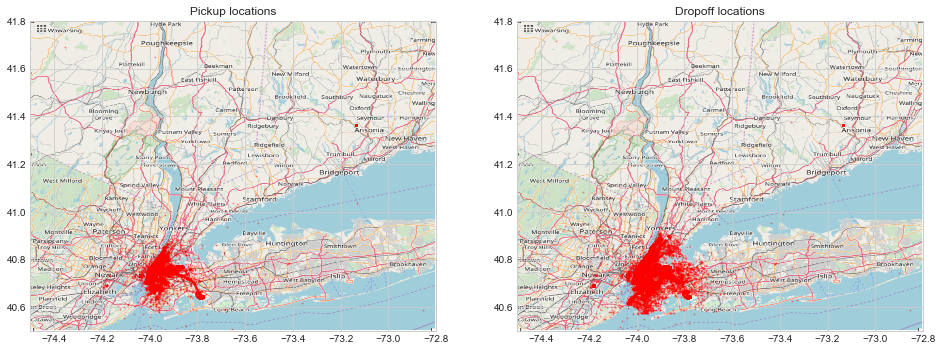

In [32]:
## Plot training data on map
plot_on_map(train_df, NYC_BB, nyc_map, s=1, alpha=0.3)

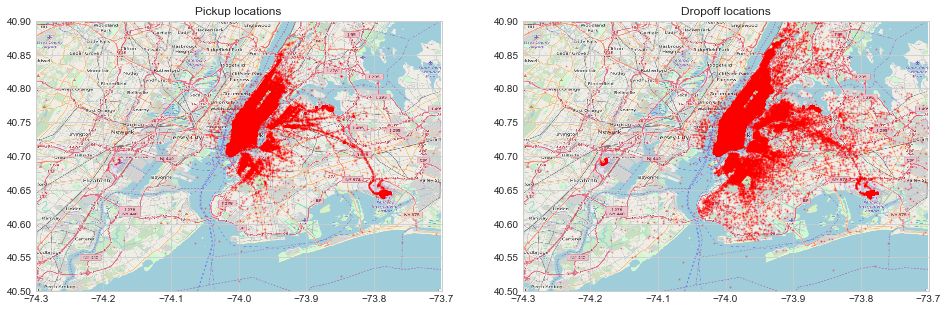

In [33]:
## Plot training data on map zoomed in
plot_on_map(train_df, NYC_BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

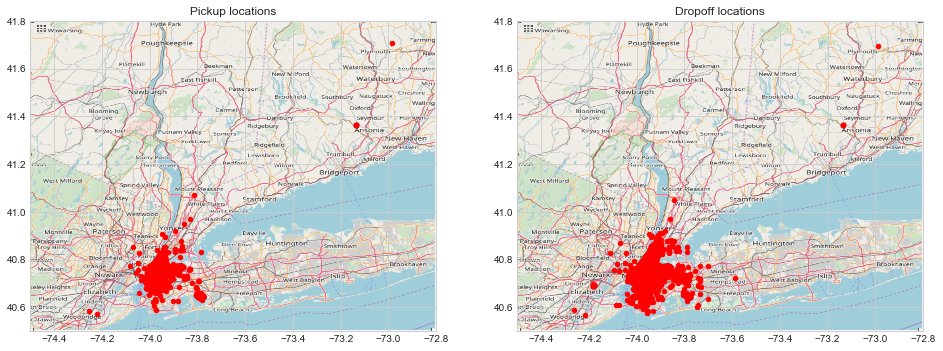

In [34]:
## Plot test data on map
plot_on_map(test_df, NYC_BB, nyc_map, alpha=1.0, s=20)

In [35]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(idx.pickup_longitude, idx.pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(idx.dropoff_longitude, idx.dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

An other interesting way to visualize the data Albert learned from this kernel: https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation. By using very small dot sizes the actual streets of New York become visible.

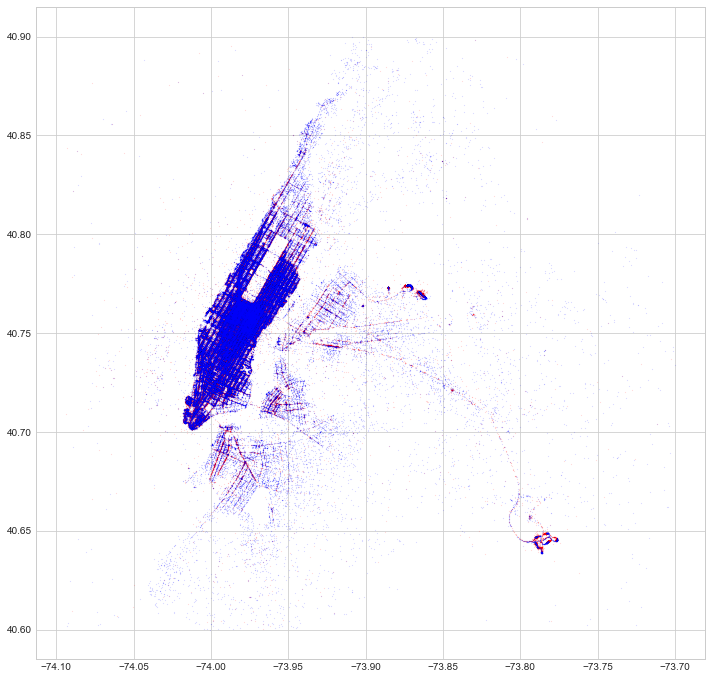

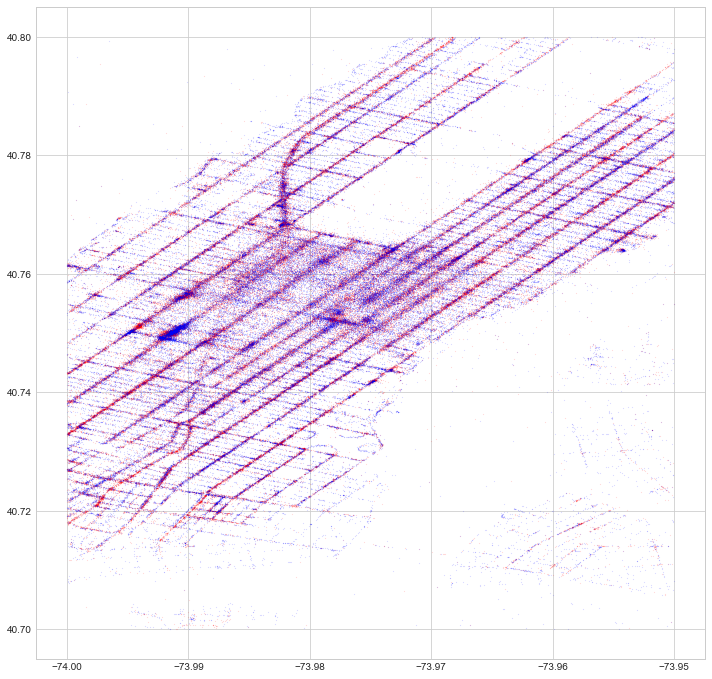

In [36]:
plot_hires(train_df, (-74.1, -73.7, 40.6, 40.9))
plot_hires(train_df, (-74, -73.95, 40.7, 40.8))

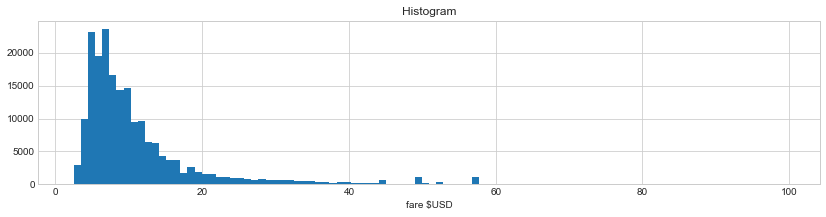

In [37]:
## Plot histogram of fare
train_df[train_df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

The small spikes between \$40 and \$60 could indicate some fixed fare price (e.g. to/from airport). This will be explored further below.

## Removing datapoints in water

These datapoints are clearly erraneous and I can't think of a way to fix them and get useful info from them, so we'll work to remove them.  For this Albert used Photoshop to threshold on the blue color of the water and to cleanup the map. The resulting map is show below.

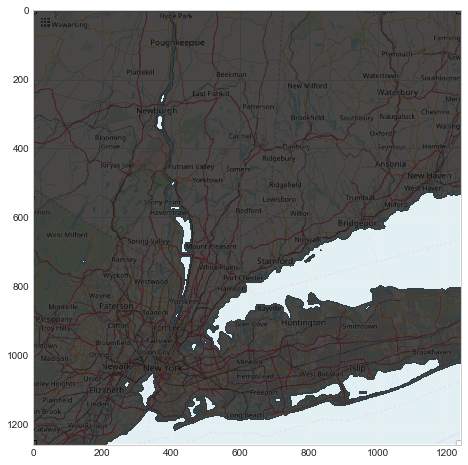

In [38]:
## Read nyc mask and turn into boolean map with land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

Next, we convert longitude/latitude coordinates to xy pixel coordinates using `lonlat_to_xy`. Note that the y coordinate is reversed as the image y-axis goes from top to bottom.  Then a boolean index is calculated using `nyc_mask` and we use a function to remove the offending datapoints.

In [39]:
def remove_datapoints_from_water(df, BB, nyc_mask, verbose=False):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    if verbose:
        print("Removing all rows with a datapoint in the water:")
        old_size = len(df)
        print("Old size: {}".format(old_size))
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    df = df.loc[idx]

    if verbose:
        print("Number of trips in water: {}".format(np.sum(~idx)))
        new_size = len(df)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    # return only datapoints on land
    return df

In [40]:
train_df = remove_datapoints_from_water(train_df, NYC_BB, nyc_mask, verbose=True)

Removing all rows with a datapoint in the water:
Old size: 195185
Number of trips in water: 34
New size: 195151
Dropped 34 records, or 0.02%


Now let's see if all outliers in the water are still there.

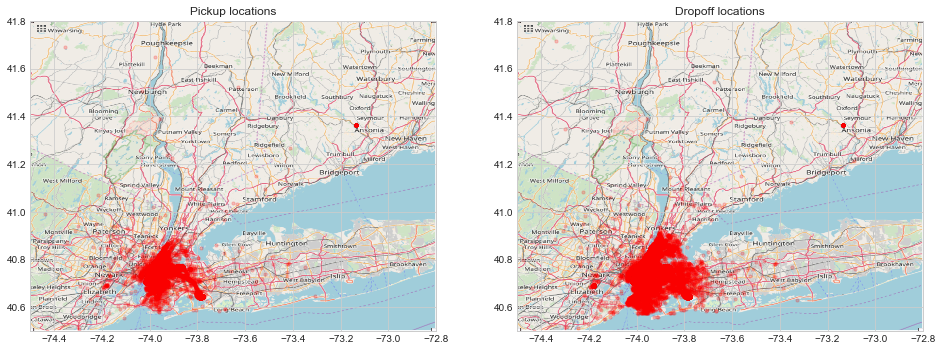

In [41]:
# plot training data
plot_on_map(train_df, NYC_BB, nyc_map)

### Datapoint density per sq km


The above scatterplot gives a quick impression of the density, but it's more accurate to use actual counts of datapoints.  Lets plot out the hotspots:

In [42]:
def distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    ## Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    ## Haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def apply_distance(df, verbose=False):
    df['distance_km'] = distance(df.pickup_latitude, df.pickup_longitude,
                                df.dropoff_latitude, df.dropoff_longitude)
    if verbose:
        display(df.distance_km.describe())

    return df

## First calculate two arrays with datapoint density per sq km
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # Prepare arrays

"""
To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
This function needs an array with the (location) bins for counting the number of datapoints per bin.
"""
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin

delta_lon = (NYC_BB[1]-NYC_BB[0]) / n_lon # bin longutide width
delta_lat = (NYC_BB[3]-NYC_BB[2]) / n_lat # bin latitude height

bin_width_kms = distance(NYC_BB[2], NYC_BB[1], NYC_BB[2], NYC_BB[0]) / n_lon # Bin width in kms
bin_height_kms = distance(NYC_BB[3], NYC_BB[0], NYC_BB[2], NYC_BB[0]) / n_lat # Bin height in kms

for i in range(n_lon+1):
    bins_lon[i] = NYC_BB[0] + i * delta_lon

for j in range(n_lat+1):
    bins_lat[j] = NYC_BB[2] + j * delta_lat
    
## Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(train_df.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(train_df.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(train_df.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(train_df.dropoff_latitude, bins_lat)

"""
Count per grid bin
note: as the density_pickup will be displayed as image, the first index is the y-direction, 
      the second index is the x-direction. Also, the y-direction needs to be reversed for
      properly displaying (therefore the (n_lat-j) term)
"""
dxdy = bin_width_kms * bin_height_kms

for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

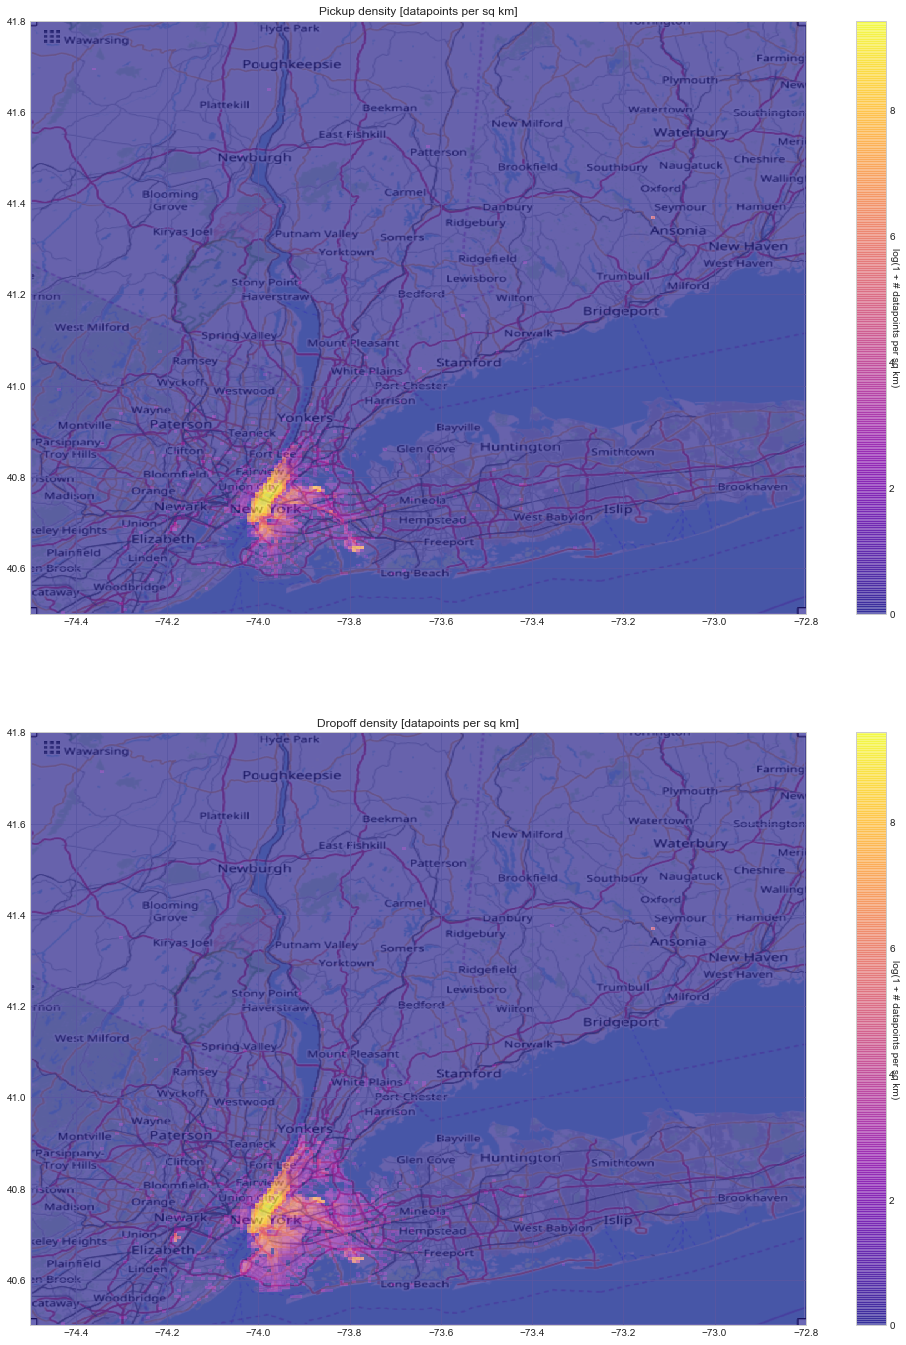

In [43]:
## Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))

axs[0].imshow(nyc_map, zorder=0, extent=NYC_BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=NYC_BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + # datapoints per sq km)', rotation=270)

axs[1].imshow(nyc_map, zorder=0, extent=NYC_BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=NYC_BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + # datapoints per sq km)', rotation=270)

The datapoints concentrate around Manhatten and the three airports (JFK, EWS, LGR), along with a hotspot near Seymour (upper right corner).

### Longer distance, higher fare

First, lets calculate the straight-line distance between points.

C:\Users\Watki\Anaconda3\envs\MLND\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in sqrt


count    195151.000000
mean          3.333012
std           3.808873
min           0.000000
25%           1.256674
50%           2.155216
75%           3.908578
max         104.034760
Name: distance_km, dtype: float64

Text(0.5,1,'Histogram ride distances in km')

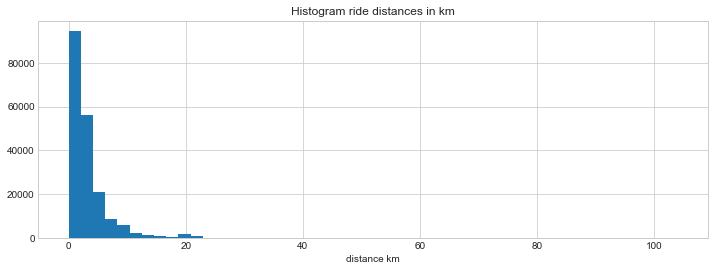

In [44]:
## Add new column to dataframe with distance in kms
train_df = apply_distance(train_df, True)

train_df.distance_km.hist(bins=50, figsize=(12,4))
plt.xlabel('distance km')
plt.title('Histogram ride distances in km')

It seems that most rides are just short rides, with a small peak at ~20 kms. This peak could be due to airport drives.

Let's also see if `passenger_count` changes anything.

In [45]:
train_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()

distance_km  fare_amount
passenger_count                          
1                   3.284815    11.200727
2                   3.510602    11.818170
3                   3.347162    11.365024
4                   3.440187    11.718715
5                   3.342155    11.211677
6                   3.505991    12.400455

## Baseline

If the model can't beat a simple calculation of applying the average dollars per km, then the model won't be able to justify its computational cost.  So, I'll use the average of \$3.40 USD/km (with anything under a total of $2.50 rounded up) as my baseline.

In [46]:
print("Average $USD/km : {:0.2f}".format(train_df.fare_amount.sum()/train_df.distance_km.sum()))

Average $USD/km : 3.40


## Plot Fare and Distance
To confirm that more than just the distance goes into a taxi's fare, let's plot the two and if we don't get a straight line, we'll know that there's more that goes into it.

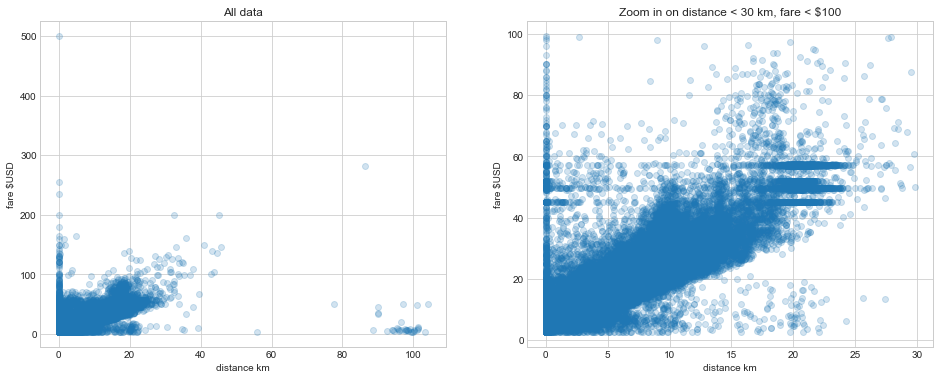

In [47]:
## Scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(train_df.distance_km, train_df.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

## Zoom in on part of data
idx = (train_df.distance_km < 30) & (train_df.fare_amount < 100)
axs[1].scatter(train_df[idx].distance_km, train_df[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance km')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 30 km, fare < $100');

### Observations:
- Many trips are listed at a 0 distance.  There might be some common factor that helps explain these trips.  Let's look into that next.
- Certain fares seem to have high numbers across a wide range of distances (notice the horizontal lines).  We will have to investigate why that is.
- Generally, there is a linear correlation between distance and fare, but that grouping is very broad, so there must be many more factors that go into determining the fare.
 - Indeed, when researching it from outside sources, you can find explanations of all the aspects that go into the cost calculation:
 - https://www.priceoftravel.com/555/world-taxi-prices-what-a-3-kilometer-ride-costs-in-72-big-cities/
 - We find initial charges, time rates, distance rates that vary depending on the speed of traffic, differing rates at day vs night, rush hour surcharges, county surcharges, taxes, bridge tolls and other factors.
 
Knowing all these factors we could theoretically hard code our own decision tree and try to recreate the specific algorithm that is inside each taxi meter; then we'd only have to predict the route the driver would choose to take and the travel time for that time of day.  However, I believe that misses the point of machine learning and this competition, so I'm going to try to train my algorithm to pick up on all of these subtleties without having to spell everything out.

In [48]:
def split_distance(df, split_point=.1, verbose=False):
    if verbose:
        print("Removing all distances less than {} km:".format(split_point))
        old_size = len(df)
        print("Old size: {}".format(old_size))

    long = df.loc[df['distance_km'] >= split_point]
    short = df.loc[df['distance_km'] < split_point]

    if verbose:
        new_size = len(long)
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Separated out {} records, or {:.2f}%".format(difference, percent))
    
    return short, long

In [49]:
short_train, train_df = split_distance(train_df, verbose=True)

train_df.describe()

Removing all distances less than 0.1 km:
Old size: 195151
New size: 191878
Separated out 3273 records, or 1.68%


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  191878.000000     191878.000000    191878.000000      191878.000000   
mean       11.300525        -73.975540        40.751106         -73.974464   
std         9.449771          0.035593         0.027889           0.034829   
min         2.500000        -74.438232        40.511086         -74.474594   
25%         6.000000        -73.992271        40.736698         -73.991470   
50%         8.500000        -73.982079        40.753555         -73.980553   
75%        12.500000        -73.968506        40.767554         -73.965425   
max       281.049988        -73.137390        41.692429         -73.091019   

       dropoff_latitude  passenger_count           hour    day_of_week  \
count     191878.000000    191878.000000  191878.000000  191878.000000   
mean          40.751461         1.690063      13.523275       3.038895   
std            0.031285         1.306303       6.503451       1.949300   
min           40.514439         1.000000       0.000000       0.000000   
25%           40.735741         1.000000       9.000000       1.000000   
50%           40.753994         1.000000      14.000000       3.000000   
75%           40.768391         2.000000      19.000000       5.000000   
max           41.714634         6.000000      23.000000       6.000000   

        day_of_month           week          month           year  \
count  191878.000000  191878.000000  191878.000000  191878.000000   
mean       15.683961      25.497577       6.275368      11.747350   
std         8.673236      14.977862       3.444475       1.868156   
min         1.000000       1.000000       1.000000       9.000000   
25%         8.000000      13.000000       3.000000      10.000000   
50%        16.000000      24.000000       6.000000      12.000000   
75%        23.000000      39.000000       9.000000      13.000000   
max        31.000000      53.000000      12.000000      15.000000   

         distance_km  
count  191878.000000  
mean        3.389686  
std         3.816210  
min         0.100065  
25%         1.296263  
50%         2.194182  
75%         3.959872  
max       104.034760

In [50]:
short_train.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  3273.000000       3273.000000      3273.000000        3273.000000   
mean     13.439159        -73.949150        40.756508         -73.949142   
std      20.959126          0.119928         0.087821           0.119928   
min       2.500000        -74.429329        40.500046         -74.429329   
25%       4.100000        -73.990784        40.732376         -73.990814   
50%       6.500000        -73.976608        40.752289         -73.976692   
75%      11.300000        -73.949547        40.767139         -73.949486   
max     500.000000        -73.085747        41.505344         -73.085762   

       dropoff_latitude  passenger_count         hour  day_of_week  \
count       3273.000000      3273.000000  3273.000000  3273.000000   
mean          40.756500         1.613504    13.188818     3.051635   
std            0.087821         1.248236     6.486334     1.954109   
min           40.500046         1.000000     0.000000     0.000000   
25%           40.732307         1.000000     9.000000     1.000000   
50%           40.752258         1.000000    14.000000     3.000000   
75%           40.767178         2.000000    19.000000     5.000000   
max           41.505344         6.000000    23.000000     6.000000   

       day_of_month         week        month         year  distance_km  
count   3273.000000  3273.000000  3273.000000  3273.000000  3273.000000  
mean      15.644974    25.429270     6.254201    11.340972     0.010511  
std        8.648803    14.972018     3.451927     1.768327     0.022870  
min        1.000000     1.000000     1.000000     9.000000     0.000000  
25%        8.000000    12.000000     3.000000    10.000000     0.000000  
50%       15.000000    25.000000     6.000000    11.000000     0.000000  
75%       23.000000    38.000000     9.000000    13.000000     0.004356  
max       31.000000    53.000000    12.000000    15.000000     0.099768

In [51]:
short_train.loc[short_train['distance_km'] == 0.0].head()

key  fare_amount  pickup_longitude  \
102   2009-03-25 00:08:52.0000001         52.0        -74.035835   
187   2014-01-08 21:55:58.0000006          6.5        -73.998489   
264   2012-08-25 01:53:42.0000005          7.5        -73.995895   
283  2009-12-14 12:33:00.00000075          6.9        -73.982430   
385   2014-03-12 18:12:44.0000006         12.0        -73.844902   

     pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
102        40.747318         -74.035835         40.747318                1   
187        40.726303         -73.998489         40.726303                1   
264        40.746452         -73.995895         40.746452                1   
283        40.745747         -73.982430         40.745747                1   
385        40.736317         -73.844902         40.736317                1   

     hour  day_of_week  day_of_month  week  month  year  distance_km  
102     0            2            25    13      3     9          0.0  
187    21            2             8     2      1    14          0.0  
264     1            5            25    34      8    12          0.0  
283    12            0            14    51     12     9          0.0  
385    18            2            12    11      3    14          0.0

In [52]:
test_df = apply_distance(test_df, True)

short_test, long_test = split_distance(test_df, verbose=True)

count    9914.000000
mean        3.435371
std         3.972374
min         0.000000
25%         1.298277
50%         2.217412
75%         4.045302
max        99.996040
Name: distance_km, dtype: float64

Removing all distances less than 0.1 km:
Old size: 9914
New size: 9790
Separated out 124 records, or 1.25%


In [53]:
short_test.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count        124.000000       124.000000         124.000000        124.000000   
mean         -73.939261        40.770322         -73.939245         40.770322   
std            0.153912         0.113946           0.153908          0.113946   
min          -74.047394        40.622553         -74.047394         40.622553   
25%          -73.988079        40.739215         -73.988135         40.739215   
50%          -73.976690        40.752883         -73.976690         40.752883   
75%          -73.955018        40.769847         -73.955018         40.770109   
max          -73.137393        41.366138         -73.137393         41.366138   

       passenger_count        hour  day_of_week  day_of_month        week  \
count       124.000000  124.000000   124.000000    124.000000  124.000000   
mean          1.741935   12.822581     2.822581     16.983871   29.419355   
std           1.354733    6.629631     2.052357      8.745716   13.262881   
min           1.000000    0.000000     0.000000      1.000000    3.000000   
25%           1.000000    7.750000     1.000000     10.000000   20.000000   
50%           1.000000   13.000000     3.000000     19.000000   29.500000   
75%           2.000000   18.000000     5.000000     24.000000   40.000000   
max           6.000000   23.000000     6.000000     31.000000   51.000000   

            month        year  distance_km  
count  124.000000  124.000000   124.000000  
mean     7.145161   11.427419     0.012906  
std      3.091277    1.711622     0.024845  
min      1.000000    9.000000     0.000000  
25%      5.000000   10.000000     0.000000  
50%      7.000000   11.000000     0.000000  
75%     10.000000   13.000000     0.012726  
max     12.000000   15.000000     0.097406

In [54]:
test_df.loc[test_df['distance_km'] == 0.0].head()

key  pickup_longitude  pickup_latitude  \
121  2014-06-14 13:39:00.000000191        -73.980590        40.747682   
279    2010-09-05 22:31:32.0000002        -74.047394        40.785789   
318  2009-06-10 16:55:00.000000131        -73.985862        40.744027   
417  2011-06-24 12:03:00.000000145        -73.964615        40.777620   
423   2011-06-24 12:03:00.00000086        -73.955065        40.771505   

     dropoff_longitude  dropoff_latitude  passenger_count  hour  day_of_week  \
121         -73.980590         40.747682                1    13            5   
279         -74.047394         40.785789                1    22            6   
318         -73.985862         40.744027                1    16            2   
417         -73.964615         40.777620                1    12            4   
423         -73.955065         40.771505                1    12            4   

     day_of_month  week  month  year  distance_km  
121            14    24      6    14          0.0  
279             5    35      9    10          0.0  
318            10    24      6     9          0.0  
417            24    25      6    11          0.0  
423            24    25      6    11          0.0

It's hard to imagine records for distances less than 0.1 km (328 feet or 100 meters; which is less than the length of most blocks) as being accurate data except in very rare edge cases.  But only about 1% of the datapoints in the train and test set are affected by this discrepancy.  They seem to happen at a relatively even distribution across a wide range of fares, locations, times and dates.

And since there seems to be no aparent rhyme or reason to these unreasonably short distances, their existence would probably only confuse the model, which is why I've removed them.  Even though the test set also contains unreasonably short distances, I don't think there's a good way to accurately learn from the ones in the train set, and so the model will have to just guess at those based on other related features.  With the RMSE metric, I don't think this 1% of datapoints will throw off the accuracy too drastically.

While we're questioning the validity of the test data, lets check it for datapoints in the water.

In [55]:
remove_datapoints_from_water(test_df, NYC_BB, nyc_mask, verbose=True)
len(test_df)

Removing all rows with a datapoint in the water:
Old size: 9914
Number of trips in water: 2
New size: 9912
Dropped 2 records, or 0.02%


9914

And sure enough, there are a couple of datapoints in the water, but that's not too bad.

### Fixed fee airport trips

It's not uncommon for taxis to charge fixed rates for trips to/from an airport.  Let's check and see if that's a factor in this dataset.

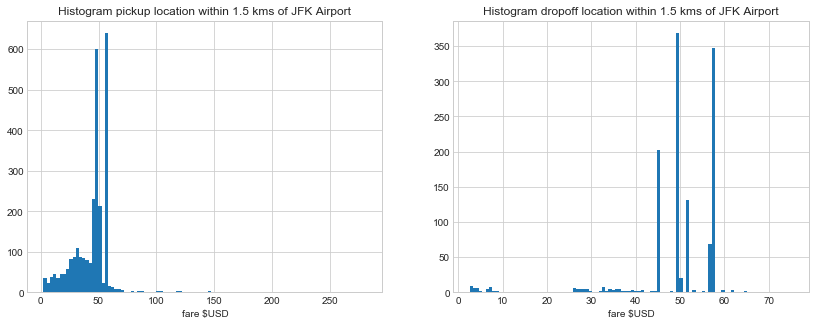

In [56]:
## JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(loc, name, range=1.5):
    ## Select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    idx = (distance(train_df.pickup_latitude, train_df.pickup_longitude, loc[1], loc[0]) < range)
    train_df[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} kms of {}'.format(range, name))

    idx = (distance(train_df.dropoff_latitude, train_df.dropoff_longitude, loc[1], loc[0]) < range)
    train_df[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} kms of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')

It definitely looks like trips to and from an airport run at a fixed total rate.

Let's also check the other two big airports.

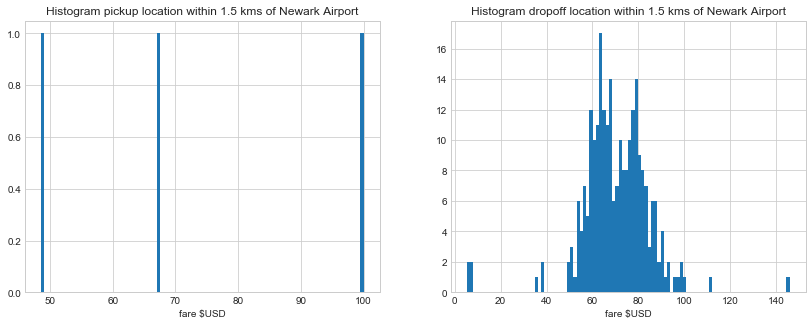

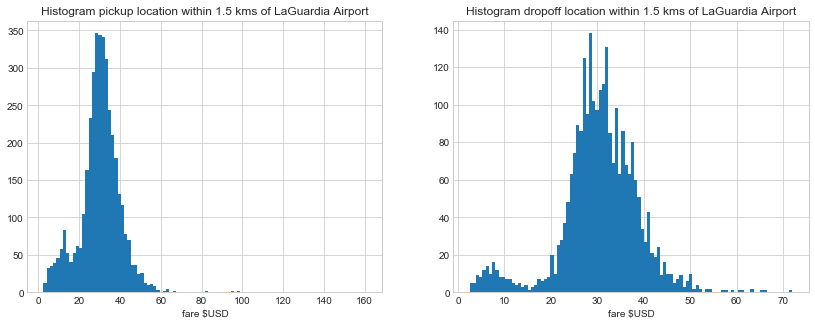

In [57]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA

plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

While I could certainly anticipate these special cases, and create a complex filter to catch all the fixed fare airport rides, then train with extra columns.  This would be not too dissimilar to skipping the model completely for these datapoints and hard coding in some rules for any rides to or from a certain distance from an airport.  However, that neglects the whole point of machine learning, which is to avoid hard coding in complex rules.  Furthermore, I'm using feature crosses on the lat/lon data so the model will likely be able to notice these patterns on its own and hopefully predict the flat rates without prompting.

I think the preparation of the data I've done so far has been sufficient to set this model up for success, so now I just need to apply it to all the data and feed it to the model.

## Create a hashing function to separate the train data into train and validate

In [58]:
def split_by_hash(df, train_percent=80):
    """
    This function splits the dataset in a repeatable manner using hashes of the key column.
    
    train_percent (int) is the percent of the dataset that gets divided into the train file, with the remaining percent going into the validate file.
    example: train_percent=75 would result in roughly 25% of the data going into the validate file
    """
    df["hashed_result"] = df.key.apply(hash) % 100

    train = df[df.hashed_result < train_percent]
    validate = df[df.hashed_result >= train_percent]
    
    train.drop(columns='hashed_result', inplace=True)
    validate.drop(columns='hashed_result', inplace=True)
    
    return train, validate

## Prepare train and validation files on the full dataset
The below function takes around 5 hours to run in full.

Note: I was able to run this smoothly until chunk 28, which ran into an IndexError in the remove_datapoints_from_water function, so I saved a copy of the first 27 chunks as a smaller dataset (if 27 million rows is considered small) and tried again.  It encountered the error again on the same index 1282, but I couldn't find anything out of the ordinary.  So in the interest of time, I `try/except` skipped that error, because it should hurt things too badly if a few datapoints in the water get missed.  I also added the `if count` check so that I could just start appending to the previous file from where it left off.

In [61]:
def prepare_train_valid(file, BB, verbose=False, chunksize=1000000, train_percent=80):
    """
    NOTE: If rerunning this, make sure to delete the previous v1-train/valid files first.
    """
    
    count = 0
    train_file = "taxi-train.csv"
    validation_file = "taxi-valid.csv"
    for df in pd.read_csv(file, chunksize=chunksize, parse_dates=["pickup_datetime"]):
        count += 1
        print("Processing chunk: {} \r".format(count),)
        
        if count > 27:
            df = fix_fares(df, verbose)
            df = drop_nan(df, verbose)
            df = drop_0s(df, verbose)
            df = latlon_outlier_fix(df, BB, verbose)
            df = prepare_time_features(df, verbose, drop=True)
            
            try:
                df = remove_datapoints_from_water(df, NYC_BB, nyc_mask, verbose)
            except IndexError:
                print("Ignored Index Error")
            
            df = apply_distance(df, verbose)
            short_train, df = split_distance(df, verbose)
            
    #         df = downcast(df, verbose) # Not using due to possible issues with dtypes in TF
    
            train_df, validate_df = split_by_hash(df, train_percent)

            train_df.to_csv(train_file, index=False, header=False, mode='a')
            validate_df.to_csv(validation_file, index=False, header=False, mode='a')

In [62]:
prepare_train_valid("./datafiles/train.csv", NYC_BB)

Processing chunk: 1 
Processing chunk: 2 
Processing chunk: 3 
Processing chunk: 4 
Processing chunk: 5 
Processing chunk: 6 
Processing chunk: 7 
Processing chunk: 8 
Processing chunk: 9 
Processing chunk: 10 
Processing chunk: 11 
Processing chunk: 12 
Processing chunk: 13 
Processing chunk: 14 
Processing chunk: 15 
Processing chunk: 16 
Processing chunk: 17 
Processing chunk: 18 
Processing chunk: 19 
Processing chunk: 20 
Processing chunk: 21 
Processing chunk: 22 
Processing chunk: 23 
Processing chunk: 24 
Processing chunk: 25 
Processing chunk: 26 
Processing chunk: 27 
Processing chunk: 28 


C:\Users\Watki\Anaconda3\envs\MLND\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Processing chunk: 29 
Processing chunk: 30 
Processing chunk: 31 
Processing chunk: 32 
Processing chunk: 33 
Processing chunk: 34 
Processing chunk: 35 
Processing chunk: 36 
Processing chunk: 37 
Processing chunk: 38 
Processing chunk: 39 
Processing chunk: 40 
Processing chunk: 41 
Processing chunk: 42 
Processing chunk: 43 
Processing chunk: 44 
Processing chunk: 45 
Processing chunk: 46 
Processing chunk: 47 
Processing chunk: 48 
Processing chunk: 49 
Processing chunk: 50 
Processing chunk: 51 
Processing chunk: 52 
Processing chunk: 53 
Processing chunk: 54 
Processing chunk: 55 
Processing chunk: 56 


## Prepare test file

...with compatible formatting if needed, but all of the non-destructive formatting was already done above during data exploration.

In [59]:
# test_df = downcast(test_df, True)

test_df.to_csv("taxi-test.csv", index=False)

In [60]:
keyless_test_df = test_df.drop(columns="key")

keyless_test_df.to_csv("keyless-taxi-test.csv", index=False)

### Convert test dataset to a json format
This is for doing batch prediction on Google Cloud ML Engine.

In [61]:
test_df.to_json("taxi_test_unformatted.json", orient = "records", date_format = "epoch",
                double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)

In [62]:
keyless_test_df.to_json("keyless_taxi_test_unformatted.json", orient = "records", date_format = "epoch",
                double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)

In [63]:
import json

json_file = open('keyless_taxi_test_unformatted.json', 'r')
json_file = json.load(json_file)
new_json = open('keyless_taxi_test.json', 'a+')

for row in json_file:
    new_row = json.dumps(row)
    new_json.write(new_row + "\n")
    
new_json.close()

In [64]:
import json

json_file = open('taxi_test_unformatted.json', 'r')
json_file = json.load(json_file)
new_json = open('taxi_test.json', 'a+')

for row in json_file:
    new_row = json.dumps(row)
    new_json.write(new_row + "\n")
    
new_json.close()

In [66]:
import json
prediction_df = pd.DataFrame()

prediction_json = open("./datafiles/taxifare_prediction2.json", 'r')
for row in prediction_json:
    jrow = json.loads(row)
    prediction_row = pd.DataFrame.from_dict(jrow)
    prediction_df = pd.concat([prediction_df, prediction_row], ignore_index=True)    
prediction_json.close()

prediction_json = open("./datafiles/taxifare_prediction1.json", 'r')
for row in prediction_json:
    jrow = json.loads(row)
    prediction_row = pd.DataFrame.from_dict(jrow)
    prediction_df = pd.concat([prediction_df, prediction_row], ignore_index=True)    
prediction_json.close()

prediction_df.describe()

predictions
count  9914.000000
mean     11.444664
std       8.859412
min       3.119109
25%       6.594593
50%       8.534064
75%      12.460252
max     102.921844

In [69]:
submission_df = test_df
submission_df['fare_amount'] = prediction_df

submission_df.head()

key  pickup_longitude  pickup_latitude  \
0  2015-01-27 13:08:24.0000002        -73.973320        40.763805   
1  2015-01-27 13:08:24.0000003        -73.986862        40.719383   
2  2011-10-08 11:53:44.0000002        -73.982524        40.751260   
3  2012-12-01 21:12:12.0000002        -73.981160        40.767807   
4  2012-12-01 21:12:12.0000003        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  hour  day_of_week  \
0         -73.981430         40.743835                1    13            1   
1         -73.998886         40.739201                1    13            1   
2         -73.979654         40.746139                1    11            5   
3         -73.990448         40.751635                1    21            5   
4         -73.988565         40.744427                1    21            5   

   day_of_month  week  month  year  distance_km  fare_amount  
0            27     5      1    15     2.323260    10.100850  
1            27     5      1    15     2.425353    10.827985  
2             8    40     10    11     0.618628     4.794265  
3             1    48     12    12     1.961033     8.774893  
4             1    48     12    12     5.387301    16.917740

In [70]:
submission_df.to_csv('taxi-predict-v2.1.csv', columns=['key', 'fare_amount'], index=False)